## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


### Load and preprocess data

In [4]:
import glob
import pandas as pd
gt = pd.read_csv("facialkKeypoints/data/gt.csv")
gt = gt.set_index("filename")

In [5]:
gt.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
filename,,,,,,,,,,,,,,,,,,,,,
00000.jpg,51,51,127,60,169,65,203,52,68,77,...,193,84,156,144,92,174,140,180,168,179
00001.jpg,21,20,36,18,57,19,80,25,23,27,...,78,33,43,46,31,61,45,66,60,65
00002.jpg,23,116,39,83,47,57,56,19,36,115,...,62,31,91,86,106,122,115,100,121,81
00003.jpg,29,18,63,25,84,32,105,34,38,31,...,95,45,72,71,46,83,63,87,75,89
00004.jpg,31,53,76,44,107,38,136,33,40,67,...,129,49,111,105,72,137,106,132,126,121


In [6]:
file_path = "facialkKeypoints/data/images/00000.jpg"



In [7]:
import cv2

In [8]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize

def load_imgs_and_keypoints(dirname='facial-keypoints'):
    # Write your code for loading images and points here
    imgs = []
    points = []
    for file_path in glob.glob("facialkKeypoints/data/images/*"):
        img = cv2.imread(file_path)
        img = cv2.resize(img, (100,100), cv2.INTER_AREA)
        imgs.append(img)
#         print(img)
        name = file_path.split("/")[-1]
        features = gt.loc[name]
        x = pd.Series(features,index=list(map(lambda x: "x"+str(x), range(1,15))))
        y = pd.Series(features,index=list(map(lambda x: "y"+str(x), range(1,15))))
#         print(img.shape)
        x = x/img.shape[0]
        y = y/img.shape[1]
#         x = pd.Series(x,index=list(map(lambda x: "x"+str(x), range(1,15))))
#         y = pd.Series(y,index=list(map(lambda x: "y"+str(x), range(1,15))))        
        features = pd.concat([x,y])
        
        
#         features = (features)
#         print(features)
        points.append(features-.5)
#         print(file_path)
#         break
        
    return imgs, points

imgs, points = load_imgs_and_keypoints()

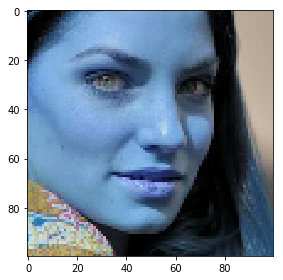

In [9]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])


### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

In [10]:
points[1].x1

-0.29000000000000004

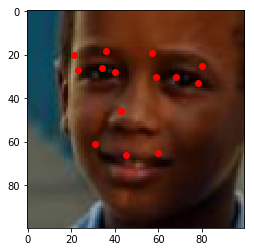

In [11]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    for i in range(1,15):
        plt.scatter((points["x"+str(i)]+.5)*100, (points["y"+str(i)]+.5)*100,c="r")
    plt.show()
        
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [12]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

In [13]:
s = "hello world"

In [14]:
s[-1::-1]

'dlrow olleh'

In [15]:
import numpy as np
imgs[0].shape

(100, 100, 3)

In [ ]:
def flip_img(img, points):
    # Write your code for flipping here
    max_val = img.shape[1]
    i = list(pd.Series(points,index=list(map(lambda x: "x"+str(x), range(1,15)))))
    y = pd.Series(points,index=list(map(lambda x: "y"+str(x), range(1,15))))
    i = list(map(lambda x: max_val-x, i))
    i = pd.Series(i,index=list(map(lambda x: "x"+str(x), range(1,15))))

    return img[:,-1:0:-1], pd.concat([i,y])
    

f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [ ]:
# Write your code here
aug_train = map(lambda x : flip_img(x[0], x[1]), zip(imgs,points))

In [ ]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

In [ ]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [ ]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(28))
# Define here your model

Time to train! 

In [ ]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(optimizer=Adam(), loss="mean_squared_error")